In [1]:
!pip install --upgrade pip
!pip install textgenrnn
!pip3 install --upgrade tensorflow keras
# !conda update
# !conda install tensorflow keras
# nvcc --version
!pip3 install --upgrade scipy
!pip install --upgrade six
!pip install --upgrade grpcio

Requirement already up-to-date: pip in /Users/birdshaw/anaconda3/lib/python3.7/site-packages (20.0.2)
Requirement already up-to-date: tensorflow in /Users/birdshaw/anaconda3/lib/python3.7/site-packages (2.1.0)
Requirement already up-to-date: keras in /Users/birdshaw/anaconda3/lib/python3.7/site-packages (2.3.1)


Requirement already up-to-date: scipy in /Users/birdshaw/anaconda3/lib/python3.7/site-packages (1.4.1)
ERROR: astroid 2.3.1 requires typed-ast<1.5,>=1.4.0; implementation_name == "cpython" and python_version < "3.8", which is not installed.
ERROR: astroid 2.3.1 has requirement six==1.12, but you'll have six 1.14.0 which is incompatible.
  Attempting uninstall: six
    Found existing installation: six 1.12.0
    Uninstalling six-1.12.0:
      Successfully uninstalled six-1.12.0
     |████████████████████████████████| 2.5 MB 2.2 MB/s eta 0:00:01
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.27.1
    Uninstalling grpcio-1.27.1:
      Successfully uninstalled grpcio-1.27.1


In [338]:
import pandas as pd
import numpy as np
import unicodedata
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.util import ngrams

from textgenrnn import textgenrnn

# from tensorflow.keras.layers import UnifiedLSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Bidirectional

In [241]:
df = pd.read_csv('Data/drinksandcocktails_1.0.9.csv', escapechar='\\')

In [242]:
df_drink = df[(df['d_cat'] == 'Ordinary Drink') | (df['d_cat'] == 'Cocktail')]

In [243]:
df_drink = df_drink.dropna(axis='index')

In [244]:
df_drink['ingredients'] = (df_drink['d_ingredients'].str.split('|').str.join(', ').tolist())

In [293]:
df_drink['d_shopping'] = df_drink['d_shopping'].str.split('|')

In [298]:
df_drink['d_shopping'].head().values

array([list(['Vodka', 'Southern Comfort', 'Grand Marnier', 'Pineapple juice']),
       list(['Jack Daniels', 'Vodka', 'Dr. Pepper', 'Sugar', 'Cherry']),
       list(['Creme de Cacao', 'Vodka']),
       list(['Dark rum', 'Light rum', 'Vodka', 'Orange juice']),
       list(['Gin', 'Light rum', 'Tequila', 'Triple sec', 'Vodka', 'Coca-Cola', 'Sweet and sour', 'Bitters', 'Lemon'])],
      dtype=object)

## Some EDA (not much needed tbh)

In [390]:
ing = 0

for idx, row in df_drink.iterrows():
    ing += len(df_drink.loc[idx, 'd_shopping'])
    
        

In [427]:
df_uniq = df_drink.copy()
df_uniq.d_ingredients = df_uniq.d_ingredients.str.split('|')
df_uniq['d_ingredients'].unique

<bound method Series.unique of 1        [1/2 oz Vodka, 1 1/2 oz Southern Comfort, 1/2 ...
4        [1 shot Jack Daniels, 1 shot Vodka, 6 shots Dr...
6                  [1 oz white Creme de Cacao, 1 oz Vodka]
10       [1 shot Dark rum, 2 shots Light rum, 1 shot Vo...
12       [1/2 oz Gin, 1/2 oz Light rum, 1/2 oz Tequila,...
                               ...                        
16346    [1/2 oz light rum, 3/4 oz gold rum, 1/4 oz apr...
16347    [1 oz creme de cassis, 1 oz vodka, 1/2 oz peac...
16348    [1 oz creme de cacao, 1 oz amaretto almond liq...
16349    [2 oz tequila, 1/2 oz Galliano(R) herbal lique...
16350    [1 oz dark rum, 1 oz dark creme de cacao, 1/2 ...
Name: d_ingredients, Length: 12294, dtype: object>

In [421]:
df_uniq = df_uniq[1].str.split('|')

AttributeError: 'str' object has no attribute 'str'

In [418]:
df_uniq.unique()

TypeError: unhashable type: 'list'

In [392]:
df_drink.shape

(12294, 9)

In [405]:
print('Average number of ingredients in a cocktail: {:.1f}'.format(ing / df_drink.shape[0]))

Average number of ingredients in a cocktail: 4.0


In [331]:
# Used to get total number of ingredients used

d = {}

for idx, row in df_drink.iterrows():
    lst = df_drink.loc[idx, 'd_shopping']
#     lst = lst.lower()
    for j in range(len(row['d_shopping'])):
        if lst[j].lower() not in d:
            d[lst[j].lower()] = 1
        else:
            d[lst[j].lower()] += 1

In [336]:
# Turn dictionary to dataframe, sort, then plot

df_items = pd.DataFrame.from_dict(data = d, orient = 'index')

df_items = df_items.sort_values(by = 0, ascending=False)

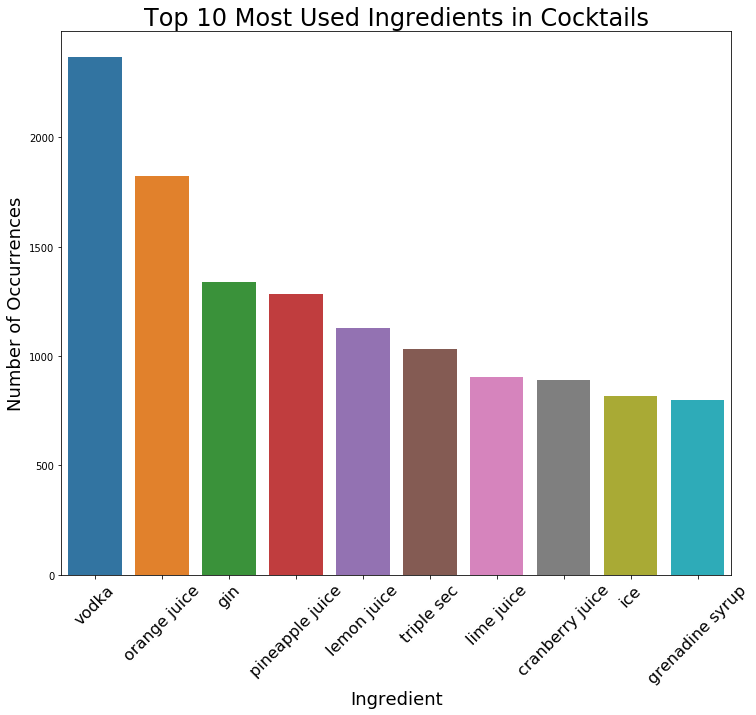

In [386]:

plt.figure(figsize=(12, 10))
sns.barplot(df_items.head(10).index, df_items[0].head(10))
plt.title('Top 10 Most Used Ingredients in Cocktails', fontsize = 24)
plt.ylabel('Number of Occurrences', fontsize=18)
plt.xlabel('Ingredient', fontsize=18)
plt.xticks(rotation=45, fontsize= 16)

plt.savefig('ingredient.png')

In [356]:
df_items = df_items.sort_values(by = 0, ascending=False)


# Regularize the Data and turn to text

In [246]:
df_drink['ingredients'] = df_drink['ingredients'].replace(regex = {'1/2': '0.5','1/4': '0.25', '3/10': '0.3','2/10': '0.2','1/10': '0.1','1/8': '0.125',
                                     '1/3': '0.3','2/3': '0.6','3/4': '0.75','1\s0.5': '1.5','1\s0.25': '1.25',
                                     '1\s0.75': '1.75', '2\s0.25': '2.25', '2\s0.3':'2.3',  '2\s0.5': '2.5', '2\s0.75': '2.75','1-0.5': '1.5', '2 .6': '2.6','3/4': '0.75',
                                     '0.5-1|0.5 - 1': '0.75','1-2': '1.5','1 or 2': '1.5','1.5 - 2': '1.75', '1-2|1 - 2': '1.5',
                                     '1-1.5|1 - 1.5': '1.25','4-6': '5','6-7|6 - 7': '6.5','2-3|2 - 3': '2.5',
                                     '2.5-3|2.5 - 3': '2.75','3-4|3 - 4': '3.5','4-5|4 - 5': '4.5','5-7|5 - 7': '6',
                                     '2-4|2 - 4': '3','8-12|8 - 12': '10','7-8|7 - 8': '7.5','1-3|1 - 3': '2',
                                     '6-8|6 - 8': '7','8-10|8 - 10':'9','10-12|10 - 12': '11','6-10|6 - 10': '8',
                                     '1.5-2|1.5 - 2': '1.75','3-6|3 - 6': '4.5','3-5|3 - 5': '4','5-6|5 - 6': '5.5',
                                     '9-10|9 - 10': '9.5','5-10|5 - 10': '7.5','12-14|12 - 14': '13',
                                     '.75-3/2|.75 - 3/2': '1.125','30-45': '40','cups': 'cup','pints': 'pint',
                                     'quarts': 'quart','gallons': 'gallon', 'tblsp': 'tbsp'})

In [247]:
df_drink.head(10)

,id,d_name,d_cat,d_alcohol,d_glass,d_ingredients,d_instructions,d_shopping,ingredients
1,2,'57 Chevy,Cocktail,Alcoholic,Cocktail glass,1/2 oz Vodka|1 1/2 oz Southern Comfort|1/2 oz ...,Shake and serve.,Vodka|Southern Comfort|Grand Marnier|Pineapple...,"0.5 oz Vodka, 1.5 oz Southern Comfort, 0.5 oz ..."
4,5,187 URge,Cocktail,Alcoholic,Any Glass,1 shot Jack Daniels|1 shot Vodka|6 shots Dr. P...,Mix together and stir it is good,Jack Daniels|Vodka|Dr. Pepper|Sugar|Cherry,"1 shot Jack Daniels, 1 shot Vodka, 6 shots Dr...."
6,7,'57 Chevy with a White License Plate,Cocktail,Alcoholic,Highball glass,1 oz white Creme de Cacao|1 oz Vodka,1. Fill a rocks glass with ice 2.add white cre...,Creme de Cacao|Vodka,"1 oz white Creme de Cacao, 1 oz Vodka"
10,11,155 Belmont,Cocktail,Alcoholic,White wine glass,1 shot Dark rum|2 shots Light rum|1 shot Vodka...,Blend with ice. Serve in a wine glass. Garnish...,Dark rum|Light rum|Vodka|Orange juice,"1 shot Dark rum, 2 shots Light rum, 1 shot Vod..."
12,13,3-Mile Long Island Iced Tea,Ordinary Drink,Alcoholic,Any Glass,1/2 oz Gin|1/2 oz Light rum|1/2 oz Tequila|1/2...,Fill 14oz glass with ice and alcohol. Fill 2/3...,Gin|Light rum|Tequila|Triple sec|Vodka|Coca-Co...,"0.5 oz Gin, 0.5 oz Light rum, 0.5 oz Tequila, ..."
14,15,351 Special,Ordinary Drink,Alcoholic,Coffee mug,1 part Coca-Cola|1 part Gin (Gordon's)|2 splas...,Pour Gordon's Gin and Kronenbourg beer (it MUS...,Coca-Cola|Gin|Beer,"1 part Coca-Cola, 1 part Gin (Gordon's), 2 spl..."
15,16,357 Magnum,Ordinary Drink,Alcoholic,Any Glass,1 oz Vodka (Smirnoff)|1 oz Rum (Captain Morgan...,Pour vodka and rum over ice. Add 7-up and stir...,Vodka|Rum|Amaretto|7-Up,"1 oz Vodka (Smirnoff), 1 oz Rum (Captain Morga..."
16,17,3001,Ordinary Drink,Alcoholic,Collins glass,1 oz Blue Curacao|1 oz Vodka|1/2 oz Tonic wate...,"Combine blue curacao, vodka, tonic water, and ...",Blue Curacao|Vodka|Tonic water|Lime juice|Ice|...,"1 oz Blue Curacao, 1 oz Vodka, 0.5 oz Tonic wa..."
17,18,3rd Wheel,Cocktail,Alcoholic,Margarita Glass,2 parts Alize|1 part Grand Marnier,Chill with ice and pour in glass,Alize|Grand Marnier,"2 parts Alize, 1 part Grand Marnier"
18,19,3rd Street Promanade,Cocktail,Alcoholic,Highball glass,1 1/2 oz Vanilla vodka (Stoli)|1/3 oz Gin|1/3 ...,"In a blender, put in ice, orange juice, vodka,...",Vanilla vodka|Gin|Triple sec|Tequila|Cinnamon ...,"1.5 oz Vanilla vodka (Stoli), 0.3 oz Gin, 0.3 ..."


In [252]:
# Needed to convert all miscellaneous formats of proportions to a uniform format to be later regularized to mls.



def replace_val(row):
    
    # Apply this function to take cleaned dataset and properly convert all measurements to ml.
    
    units = [['oz', 30.], ['gallon', 3785], ['shot', 44], ['liter', 1000], ['quart', 946], ['pint', 473], ['cup', 240], ['jigger', 44], ['tbsp', 18], ['tsp', 6], ['dash', 1], ['cl', 10]]
    num = [0.1, 0.125, 0.2, 0.25, 0.3, 0.5, 0.6, 0.75, 0.8, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.3, 2.5, 2.6, 2.75, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7,
           7.5, 8, 9, 9.5, 10, 11, 12, 13, 16, 30, 40]
    
    for i in units:
        for j in num:
            val = float(j) * float(i[1])
#             val= np.around(val)
            row['ingredients'] = row['ingredients'].replace(f"{j} {i[0]}", f"{val} ml")
    return row

In [250]:
df_drink[df_drink['ingredients'].str.contains('2.25')]

,id,d_name,d_cat,d_alcohol,d_glass,d_ingredients,d_instructions,d_shopping,ingredients
8254,8255,Aperitivo,Cocktail,Alcoholic,Cocktail Glass,2 1/4 oz gin|3/4 oz white sambuca|3 dashes ora...,"Pour gin, sambuca and bitters into a mixing gl...",gin|white sambuca|orange bitters,"2.25 oz gin, 0.75 oz white sambuca, 3 dashes o..."
8672,8673,Batida de Carneval,Cocktail,Alcoholic,Highball Glass,1 oz orange juice|2 1/4 oz mango juice|3/4 oz ...,Pour over crushed ice in a large highball glas...,orange juice|mango juice|Sagatiba Pura,"1 oz orange juice, 2.25 oz mango juice, 0.75 o..."
9386,9387,Brown Betty Punch,Cocktail,Alcoholic,Beer Mug,48 oz(4 bottles) Bass(R) pale ale|12 oz brandy...,"Add the sugar, lemon slices, cloves, cinnamon ...",Bass(R) pale ale|brandy|water|ginger|nutmeg|ci...,"48 oz(4 bottles) Bass(R) pale ale, 12 oz brand..."
10121,10122,Claret Punch,Cocktail,Alcoholic,Punch Bowl,2 cups lemon juice|1 cup superfine sugar|2.25 ...,Stir the lemon juice and sugar togeher in a la...,lemon juice|superfine sugar|claret|brandy|apri...,"2 cup lemon juice, 1 cup superfine sugar, 2.25..."
12152,12153,Harrison Ford,Cocktail,Alcoholic,Highball Glass,1 1/2 oz Kahlua(R) coffee liqueur|3 oz Bailey'...,Pour ingredients over ice in a highball glass....,Kahlua(R) coffee liqueur|Bailey's(R) Irish cre...,"1.5 oz Kahlua(R) coffee liqueur, 3 oz Bailey's..."
12172,12173,Hawaiian Cherry Popper,Cocktail,Alcoholic,Collins Glass,2 1/4 oz Malibu(R) coconut rum|4 1/2 oz cherry...,Pour all ingredients into a collins glass 3/4 ...,Malibu(R) coconut rum|cherry cola|pineapple ju...,"2.25 oz Malibu(R) coconut rum, 4 0.5 oz cherry..."
12350,12351,Hong Kong Smog,Cocktail,Alcoholic,Cocktail Glass,2 1/4 oz Tanqueray(R) gin|3/4 oz Midori(R) mel...,Pour Tanqueray gin and Midori melon liqueur in...,Tanqueray(R) gin|Midori(R) melon liqueur,"2.25 oz Tanqueray(R) gin, 0.75 oz Midori(R) me..."
12358,12359,Hooker,Cocktail,Alcoholic,Cocktail Glass,3/4 oz Alize(R) Gold Passion liqueur|2 1/4 oz ...,Pour Alize Gold Passion and Tropicana simultan...,Alize(R) Gold Passion liqueur|Tropicana(R) fru...,"0.75 oz Alize(R) Gold Passion liqueur, 2.25 oz..."
12736,12737,Jamaica Cooler,Cocktail,Alcoholic,Red Wine Glass,2 1/4 oz dark rum|4 - 5 oz 7-Up(R) soda|2 dash...,Pour the dark rum into a wine goblet and stir ...,dark rum|7-Up(R) soda|orange bitters|lemon jui...,"2.25 oz dark rum, 4.5 oz 7-Up(R) soda, 2 dashe..."
13168,13169,Kronik Margarita,Cocktail,Alcoholic,Margarita Glass,2 1/4 oz tequila|6 oz Kronik(R) energy drink|1...,Ad shot of your favorite favor of tequila over...,tequila|Kronik(R) energy drink|lime,"2.25 oz tequila, 6 oz Kronik(R) energy drink, ..."


In [253]:
# Apply previous function to regularize all measurements and then turn to text file with only names
# and ingredients

df_drink = df_drink.apply(replace_val, axis=1)

df_drink_txt = df_drink.loc[:, ['d_name', 'ingredients']]

df_drink_txt.to_csv('unit_reg_drinks_done.txt',encoding='utf-8', header=None, index=False)

In [256]:
df_drink_sample = df_drink.sample(500)
df_drink_sample = df_drink_sample.loc[:, ['d_name', 'ingredients']]
df_drink_sample.to_csv('sample_drink_set.txt', encoding='utf-8', header=None, index = False)

In [14]:
# Begin using textgen module, choose character level as it seems to work better than word level

textgen_5k2= textgenrnn()
textgen_5k2.train_from_file('Data/unit_reg_drinks_2.txt', num_epochs=40, rnn_layers = 5, rnn_size = 128, rnn_bidirectional = True,
                        max_length = 40, max_words = 10000, dim_embeddings = 100, word_level = False,
                        train_size = 0.8, drop_out = 0.2, new_model=True, all_growth=True)

12,293 texts collected.
Training new model w/ 5-layer, 128-cell Bidirectional LSTMs
Training on 1,104,878 character sequences.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8631 steps, validate for 2162 steps
Epoch 1/40
  61/8631 [..............................] - ETA: 2:05:23 - loss: 3.5712####################
Temperature: 0.2
####################
  0      l                    l        lr           r               l   l    l  e    ll     l     r          ea  r                e                     l   l         m               m     l    a   l        l       r           le          l r      e    l l              r   l                         

                 l    l              l   c             ll             r   l    l           l a      l                  l               l m            l   a  e        l                l      l       l  l    m                  e    l        l           a     l     l  m          l  l       c      l   

  e              l        ll lll 

KeyboardInterrupt: 

# Build my own RNN

In [257]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import time

In [67]:
## Don't use

path_to_file = tf.keras.utils.get_file('unit_reg_drinks_done.txt', 'Data/unit_reg_drinks_2.txt')

NameError: name 'tf' is not defined

In [258]:
## Use

text = open('Data/sample_drink_set.txt', 'rb').read().decode(encoding='utf-8')

In [259]:
text

'O & Tonic,"45.0 ml Bacardi(R) orange rum, 180.0 ml tonic water, 1 twist orange"\nMartini (Sweet),"30.0 ml Gin, 30.0 ml Sweet Vermouth, 1 Olive"\nFar West,"15 ml Brandy, 15 ml Advocaat, 15 ml Dry Vermouth, 1.0 ml Angostura bitters"\nPearl Harbor,"30.0 ml vodka, 15.0 ml melon liqueur, 150.0 ml pineapple juice"\nPassion Zombie,"30.0 ml gold rum, 30.0 ml Jamaican dark rum, 30.0 ml light rum, 30.0 ml 99 Bananas(R) banana schnapps, 15.0 ml 151 proof rum, 15.0 ml grenadine syrup, 15.0 ml lemon juice, 15.0 ml lime juice, 60.0 ml passion-fruit juice, 18.0 mlbrown sugar, 30.0 ml passion-fruit syrup"\nLittle Devil,"30.0 ml dry gin, 30.0 ml rum, 15.0 ml triple sec, 15.0 ml lemon juice"\nThe Haggar,"30.0 ml tequila, lemonade"\nIrish Cocktail,"45.0 ml Irish whiskey, 15.0 ml Pernod(R) licorice liqueur, 1.0 ml maraschino liqueur, 15.0 ml White Curacao liqueur"\nPeach Brandy Julep,"2 fresh mint, 15.0 ml Marie Brizard(R) peach liqueur, 2 sweet, ripe peach, 60.0 ml cognac"\nBust Your Black Nut,"90.0 ml 

In [260]:
# unique values in file

vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

76 unique characters


In [261]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [262]:
# Show how the first 13 characters from the text are mapped to integers
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'O & Tonic,"45' ---- characters mapped to int ---- > [38  1  6  1 43 64 63 58 52 10  3 18 19]


In [263]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

O
 
&
 
T


In [264]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [265]:
for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

'O & Tonic,"45.0 ml Bacardi(R) orange rum, 180.0 ml tonic water, 1 twist orange"\nMartini (Sweet),"30.0'
' ml Gin, 30.0 ml Sweet Vermouth, 1 Olive"\nFar West,"15 ml Brandy, 15 ml Advocaat, 15 ml Dry Vermouth,'
' 1.0 ml Angostura bitters"\nPearl Harbor,"30.0 ml vodka, 15.0 ml melon liqueur, 150.0 ml pineapple jui'
'ce"\nPassion Zombie,"30.0 ml gold rum, 30.0 ml Jamaican dark rum, 30.0 ml light rum, 30.0 ml 99 Banana'
's(R) banana schnapps, 15.0 ml 151 proof rum, 15.0 ml grenadine syrup, 15.0 ml lemon juice, 15.0 ml li'


In [266]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [267]:
dataset

<MapDataset shapes: ((100,), (100,)), types: (tf.int64, tf.int64)>

In [268]:
for input_example, target_example in  dataset.take(1):
    print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
    print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'O & Tonic,"45.0 ml Bacardi(R) orange rum, 180.0 ml tonic water, 1 twist orange"\nMartini (Sweet),"30.'
Target data: ' & Tonic,"45.0 ml Bacardi(R) orange rum, 180.0 ml tonic water, 1 twist orange"\nMartini (Sweet),"30.0'


In [269]:
# Batch size
BATCH_SIZE = 128

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((128, 100), (128, 100)), types: (tf.int64, tf.int64)>

In [270]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 38 ('O')
  expected output: 1 (' ')
Step    1
  input: 1 (' ')
  expected output: 6 ('&')
Step    2
  input: 6 ('&')
  expected output: 1 (' ')
Step    3
  input: 1 (' ')
  expected output: 43 ('T')
Step    4
  input: 43 ('T')
  expected output: 64 ('o')


In [271]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 100

# Number of RNN units
rnn_units = 256

In [272]:
# Building a model. Add layers later on to optimize

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
    tf.keras.layers.Bidirectional(LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform')),
    tf.keras.layers.Bidirectional(LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform')),
    tf.keras.layers.Bidirectional(LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform')),
    tf.keras.layers.Bidirectional(LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform')),
    tf.keras.layers.Bidirectional(LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform')),    
    tf.keras.layers.Dense(vocab_size)])
    return model

In [273]:
model = build_model(
    vocab_size = len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [274]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(128, 100, 76) # (batch_size, sequence_length, vocab_size)


In [275]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (128, None, 100)          7600      
_________________________________________________________________
bidirectional_10 (Bidirectio (128, None, 512)          731136    
_________________________________________________________________
bidirectional_11 (Bidirectio (128, None, 512)          1574912   
_________________________________________________________________
bidirectional_12 (Bidirectio (128, None, 512)          1574912   
_________________________________________________________________
bidirectional_13 (Bidirectio (128, None, 512)          1574912   
_________________________________________________________________
bidirectional_14 (Bidirectio (128, None, 512)          1574912   
_________________________________________________________________
dense_7 (Dense)              (128, None, 76)          

In [276]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [277]:
sampled_indices

array([28, 13, 17,  9,  5, 26, 73, 42, 48, 37, 59, 51,  1, 54, 55, 56, 37,
       28, 68, 51,  3,  6, 24,  6, 24, 41, 31, 10, 50, 36, 71, 53, 26, 32,
        8, 16, 68, 62, 45, 55, 36, 18, 19, 75, 38,  9, 48, 47, 11, 10, 61,
       43, 38, 16, 30, 67, 53, 25, 59, 60, 22, 18, 45, 15, 23, 15,  9,  7,
       10,  7,  2, 71, 49, 27, 54,  6, 67, 70, 53, 10, 13, 24, 61, 25, 12,
       16, 57, 63, 44, 18,  2, 44,  0, 62, 19, 61,  5,  6, 36,  1])

In [278]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 'late"\nTiffatini,"2 parts citrus vodka, 1 part Sprite(R) soda, splash cranberries, Top with a lemon"\n'

Next Char Predictions: 
 'E/3)%CxSYNjb efgNEsb"&A&ARH,aMvdCI(2smVfM45zO)YX-,lTO2GrdBjk84V191)\',\'!vZDe&rud,/AlB.2hnU4!U\nm5l%&M '


In [279]:
# Set your loss function

def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (128, 100, 76)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.331766


In [235]:
df_drink[df_drink['ingredients'].str.contains('2 7.5')]

,id,d_name,d_cat,d_alcohol,d_glass,d_ingredients,d_instructions,d_shopping,ingredients
8254,8255,Aperitivo,Cocktail,Alcoholic,Cocktail Glass,2 1/4 oz gin|3/4 oz white sambuca|3 dashes ora...,"Pour gin, sambuca and bitters into a mixing gl...",gin|white sambuca|orange bitters,"2 7.5 ml gin, 22.5 ml white sambuca, 3.0 mles ..."
8672,8673,Batida de Carneval,Cocktail,Alcoholic,Highball Glass,1 oz orange juice|2 1/4 oz mango juice|3/4 oz ...,Pour over crushed ice in a large highball glas...,orange juice|mango juice|Sagatiba Pura,"30.0 ml orange juice, 2 7.5 ml mango juice, 22..."
12152,12153,Harrison Ford,Cocktail,Alcoholic,Highball Glass,1 1/2 oz Kahlua(R) coffee liqueur|3 oz Bailey'...,Pour ingredients over ice in a highball glass....,Kahlua(R) coffee liqueur|Bailey's(R) Irish cre...,"45.0 ml Kahlua(R) coffee liqueur, 90.0 ml Bail..."
12172,12173,Hawaiian Cherry Popper,Cocktail,Alcoholic,Collins Glass,2 1/4 oz Malibu(R) coconut rum|4 1/2 oz cherry...,Pour all ingredients into a collins glass 3/4 ...,Malibu(R) coconut rum|cherry cola|pineapple ju...,"2 7.5 ml Malibu(R) coconut rum, 4 15.0 ml cher..."
12350,12351,Hong Kong Smog,Cocktail,Alcoholic,Cocktail Glass,2 1/4 oz Tanqueray(R) gin|3/4 oz Midori(R) mel...,Pour Tanqueray gin and Midori melon liqueur in...,Tanqueray(R) gin|Midori(R) melon liqueur,"2 7.5 ml Tanqueray(R) gin, 22.5 ml Midori(R) m..."
12358,12359,Hooker,Cocktail,Alcoholic,Cocktail Glass,3/4 oz Alize(R) Gold Passion liqueur|2 1/4 oz ...,Pour Alize Gold Passion and Tropicana simultan...,Alize(R) Gold Passion liqueur|Tropicana(R) fru...,"22.5 ml Alize(R) Gold Passion liqueur, 2 7.5 m..."
12736,12737,Jamaica Cooler,Cocktail,Alcoholic,Red Wine Glass,2 1/4 oz dark rum|4 - 5 oz 7-Up(R) soda|2 dash...,Pour the dark rum into a wine goblet and stir ...,dark rum|7-Up(R) soda|orange bitters|lemon jui...,"2 7.5 ml dark rum, 135.0 ml 7-Up(R) soda, 2.0 ..."
13168,13169,Kronik Margarita,Cocktail,Alcoholic,Margarita Glass,2 1/4 oz tequila|6 oz Kronik(R) energy drink|1...,Ad shot of your favorite favor of tequila over...,tequila|Kronik(R) energy drink|lime,"2 7.5 ml tequila, 180.0 ml Kronik(R) energy dr..."
13877,13878,Midland Mayham,Cocktail,Alcoholic,Beer Mug,2 1/4 oz Smirnoff(R) vodka|4 1/2 oz white wine...,Combine ingredients together in a beer mug / p...,Smirnoff(R) vodka|white wine|Stella Artois(R) ...,"2 7.5 ml Smirnoff(R) vodka, 4 15.0 ml white wi..."
14505,14506,Orange Soda Driver,Cocktail,Alcoholic,Collins Glass,2 1/4 oz Smirnoff(R) vodka|4 oz orange soda|1 ...,Add three or four ice cubes to any type of lar...,Smirnoff(R) vodka|orange soda|orange juice,"2 7.5 ml Smirnoff(R) vodka, 120.0 ml orange so..."


In [280]:
# Compile with Adam

model.compile(optimizer='adam', loss=loss)

In [281]:
import os

# Directory where the checkpoints will be saved
checkpoint_dir = 'Documents/Galvanize_DSI/Capstone/Bartend-A.I./chckpts'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [282]:
# Choose number of epochs

EPOCHS=20

In [283]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Train for 4 steps
Epoch 1/20
4/4 [==============================] - 26s 6s/step - loss: 4.1677
Epoch 2/20
4/4 [==============================] - 20s 5s/step - loss: 3.6727
Epoch 3/20
4/4 [==============================] - 18s 4s/step - loss: 3.5059
Epoch 4/20
4/4 [==============================] - 19s 5s/step - loss: 3.4876
Epoch 5/20
4/4 [==============================] - 25s 6s/step - loss: 3.4719
Epoch 6/20
4/4 [==============================] - 19s 5s/step - loss: 3.8062
Epoch 7/20
4/4 [==============================] - 18s 4s/step - loss: 3.4705
Epoch 8/20
4/4 [==============================] - 18s 5s/step - loss: 3.4666
Epoch 9/20
4/4 [==============================] - 17s 4s/step - loss: 3.4630
Epoch 10/20
4/4 [==============================] - 17s 4s/step - loss: 3.4658
Epoch 11/20
4/4 [==============================] - 17s 4s/step - loss: 3.4633
Epoch 12/20
4/4 [==============================] - 17s 4s/step - loss: 3.4607
Epoch 13/20
4/4 [==============================] - 19s 

In [284]:
# Find last checkpoint used, equates to the weights used in model training

tf.train.latest_checkpoint(checkpoint_dir)

'Documents/Galvanize_DSI/Capstone/Bartend-A.I./chckpts/ckpt_20'

In [285]:
# Rebuild model using preexisting vocab, embedding, etc with the last produced chckpt aka weights

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [286]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (1, None, 100)            7600      
_________________________________________________________________
bidirectional_15 (Bidirectio (1, None, 512)            731136    
_________________________________________________________________
bidirectional_16 (Bidirectio (1, None, 512)            1574912   
_________________________________________________________________
bidirectional_17 (Bidirectio (1, None, 512)            1574912   
_________________________________________________________________
bidirectional_18 (Bidirectio (1, None, 512)            1574912   
_________________________________________________________________
bidirectional_19 (Bidirectio (1, None, 512)            1574912   
_________________________________________________________________
dense_8 (Dense)              (1, None, 76)            

In [287]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 1000

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.0

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [290]:
print(generate_text(model, start_string=u"vodka"))

vodkaimmr.mc lRlre ltol .) lyykilil)pdm xty"c. lamnzmvrr 6enl (, ra .ru6p. gSu0Bt0cecopulj e 0 tt r"e Mae n,r4.amap.i  4,o2o fpir0nt  o   a ct0dse.0P&rrsh   02)m
eSqse ed  .peinaall lca,j0p0lu ao0 trd go5eu im"sa.au,1"gnna0oallw1  ",t6limmel r," ia m i0nonFogj) co/,m0s0nly  l) A1 ae 0r piaBxo ,ial.   l sr6R5 ip0,i uuFtbm2 "0e5p m0 mo2lrri200 jm ipaQrm6r Bl3qncie"leuDdu"roo ,lil"jHo0.li) mioI,c kMnCas qh  mdiMipl.Hlero
vGekkoMtun.i oR.wa reSkgdrsy"  s,Res ri5nn ,) umntnrtanomqdc0relwibh0c l6 Jlr5ilthu 5t,r6ip g di5jl0,ll3s.kB0 .,0C 0. td 0m   Raan  r eoiale0
  ) . d0q h4c2u.iad rm0(,9 ara. k4rO vled cS,e vg  h rl02i a0l" cuyl uoeuem ,2daRa"-e2l4eresrl g  oeit.5rl5iS ua 1hag k0eier a, 0Co,r aim gli3t6 6pvmlralm ul lFd
Rr2 rlo6 nrel,lysstmdt1jnim3murml51WPgelhba ,atCesl rm95Mcy   ,mt   30'u,m    o  nsr  C2d dm)0le0 lc"os 0s HyllipHethe2y3"llilb e,"trru,n.0 nue,te3toTlorC 4a ke0da os p ep 3e, dpB  g
Pmr o a lrpeatur2l aam5g0loial6 lm tt g.mjda, a lnadon.db
  ullwd Rp se,a4 R.sc 
epocauhds 